# House pricing

The goal of this notebook is to show, using our House price dataset, how we can use the enriched information provided by the posterior in probabilistic machine learning (in particular we will focus on Bayesian linear regression) to assess the appropriateness of a probabilistic model and improve it (only looking at the training dataset).

We start by loading the data

### load dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
dftrain = pd.read_csv("../datasets/house_price_csv/train.csv",index_col='ad_id')
dftest  = pd.read_csv( "../datasets/house_price_csv/test.csv",index_col='ad_id')
dfyte=pd.read_csv("../datasets/house_price_csv/true_price.csv")
ytest_price=dfyte.Expected.values

### Data Cleaning, Features selection and preprocessing

In [2]:
#select some features columns just for the baseline model
df_subset_train = dftrain[['bathrooms','beds','surface','latitude','longitude','price']].dropna(axis=0)
df_subset_test  =  dftest[['bathrooms','beds','surface','latitude','longitude']]
df_subset_train.head()

,bathrooms,beds,surface,latitude,longitude,price
ad_id,,,,,,
9124101,3.0,5.0,321.0,53.400454,-6.445730,935000.0
9135354,4.0,4.0,144.0,53.316410,-6.385214,485000.0
9135646,3.0,5.0,321.0,53.401414,-6.446634,935000.0
9150119,5.0,5.0,312.0,53.375377,-6.056749,1475000.0
9150125,2.0,2.0,83.0,53.372130,-6.338466,410000.0


In [3]:
X = df_subset_train.iloc[:,0:-1].values #input columns
y = df_subset_train.iloc[:,-1].values.reshape(-1,1)   #output column, price
#test set
Xtest = df_subset_test.iloc[:,0:].values #input columns

#Minimum data Cleaning
ind=np.where((X[:,0]==0) & (X[:,1]==0))[0]
X=np.delete(X,ind,axis=0)#0 bathrooms, 0 bedrooms
y=np.delete(y,ind,axis=0)#0 bathrooms, 0 bedrooms

ind=np.where((X[:,2]==0))[0]
X=np.delete(X,ind,axis=0)#0 surface
y=np.delete(y,ind,axis=0)#0 surface

#Cleaning
ind=np.where((Xtest[:,0]==0) & (Xtest[:,1]==0))[0]
Xtest=np.delete(Xtest,ind,axis=0)#0 bathrooms, 0 bedrooms
ytest_price=np.delete(ytest_price,ind,axis=0)#0 bathrooms, 0 bedrooms

In [4]:
#we do  scaling so that inputs have the same scale
from sklearn.preprocessing import StandardScaler
X=np.hstack([X,X[:,[2]]**2])
xscaler = StandardScaler().fit(X)
Xn=xscaler.transform(X)
Xtest=np.hstack([Xtest,Xtest[:,[2]]**2])
Xtestn=xscaler.transform(Xtest)
yscaler = StandardScaler().fit(y)
yn=yscaler.transform(y)

## Linear regression model

We consider the following linear regression model

$$
price = \alpha + \beta_1 \text{bathrooms}+ \beta_2 \text{beds} + \beta_3 \text{surface} + \beta_4 \text{latitude} + \beta_5 \text{longitude} + \beta_6 \text{surface}^2 + noise
$$

Note that we have added $ \text{surface}^2$ to account for the nonlinear dependence of the the price on the house area (surface). We have  also assumed that there is (observation) noise in our model. We assume that the noise is Gaussian with zero mean and variance $\sigma^2$.

$$
noise \sim Normal(0,\sigma^2)
$$

Our goal is to compare 
* traditional linear regression (general `sklearn` recipe linear regression);
* probabilistic (Bayesian) linear regression

## Traditional linear regression

In [5]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(Xn, yn[:,0])
y_te_pred_n = reg.predict(Xtestn)
y_te_pred =  yscaler.inverse_transform(y_te_pred_n)#we remove negative prices
print("MAE=",(np.mean(abs(y_te_pred-ytest_price))))
print("MAPE=",(np.mean(abs(y_te_pred-ytest_price)/ytest_price)))

MAE= 231513.90271625816
MAPE= 0.390108368375628


This does not look like a good model. However, assessing what can be improved is hard, because `sklearn` recipe linear regression does not give us any measure of uncertainty about its prediction. We will now implement the corresponding probabilistic (Bayesian) linear regression and use it to assess if the above performance is good (for a linear model) or if it can be improved.

## Bayesian linear regression
We generalise the model you studied in "Notes.pdf", Chapter 4.
The only difference is that now we have 6 covariates (inputs) and not just one. So instead of having a single slope parameter we have $6$ slope parameters (the $\beta_i$).

In [6]:
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn.shape[1])#we have a beta for each column of Xn
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression relationship
    mu = alpha + pm.math.dot(beta, Xn.T)#linear regression model in matrix form
    #likelihood
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn[:,0])# be sure that observed is a 1d vector
    

The only main difference between the linear regression model in "Notes.pdf" is that here we use a different prior for the standard deviation of the noise `pm.HalfCauchy`. This is a PDF that can be used to model uncertainty about a positive variable (like sigma). Its PDF is showed hereafter. You can notice that is putting more weight on low values of sigma, in this way we model the fact that we expect sigma to be "small" (but not too small as you see from the x-axis).

Text(0.5, 0, 'sigma_n')

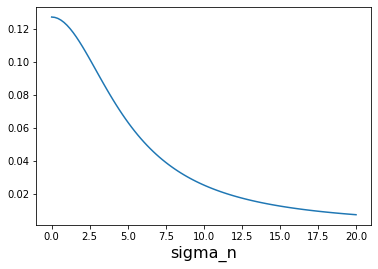

In [7]:
xx=np.linspace(0,20,100)
plt.plot(xx,np.exp(pm.HalfCauchy.dist(5).logp(xx).eval()))
plt.xlabel("sigma_n",fontsize=16)

We now compute the posterior. Since the dataset is quite large, we use a fast algorithm to compute an approximation of the posterior. It is based on a "Variational" approximation of the posterior. We do not need to know the details of the algorithm. We only need to know its parameters, that is the number of iterations of the algorithm (30000 in the example).

In [8]:
with model:
    approximation = pm.fit(30000,method='advi')#50000 are the number of iterations of the algorithms


Average Loss = 2,857.4: 100%|██████████| 30000/30000 [00:06<00:00, 4465.55it/s]
Finished [100%]: Average Loss = 2,857.4


We must verify that the number of iterations is large enough to allow the algorithm to converge. We can check it as follows:

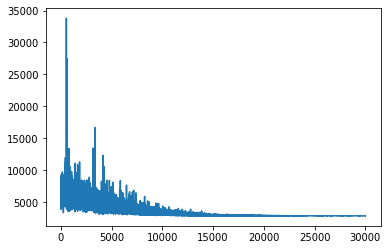

In [9]:
#we check the convergence
plt.plot(approximation.hist);

Note that the algorithm converges after about 20000 iterations and, therefore, 30000 is enough in this example (we do not need to increase it).
Now we generate samples from the posterior (5000 samples in the example)

In [10]:
posterior = approximation.sample(5000)#we sample 5000 samples from the posterior

In [11]:
posterior['beta'].shape

(5000, 6)

In [12]:
#these are 10 jointly samples of alpha and beta from the posterior
np.hstack([posterior['alpha'].reshape(-1,1),posterior['beta']])[0:10,:]

array([[-0.0068861 ,  0.26888686,  0.2828745 ,  0.78974941, -0.14895731,
         0.12272395, -0.72707028],
       [ 0.02732295,  0.26290673,  0.2830729 ,  0.80362639, -0.15331593,
         0.1383857 , -0.73955655],
       [ 0.03566953,  0.24567167,  0.30805265,  0.78059195, -0.13381102,
         0.11205246, -0.74131919],
       [-0.00591075,  0.26423711,  0.28521988,  0.78594416, -0.14167229,
         0.12585932, -0.72208871],
       [-0.0312749 ,  0.27825128,  0.31196201,  0.80561702, -0.15395559,
         0.12843163, -0.76142711],
       [-0.02139283,  0.27833954,  0.26020902,  0.84195047, -0.16187248,
         0.1017661 , -0.75573323],
       [-0.01789073,  0.30846537,  0.29267305,  0.80059978, -0.08567193,
         0.11896699, -0.77453434],
       [-0.0112258 ,  0.27106448,  0.31413767,  0.80403606, -0.15984975,
         0.13900412, -0.74011109],
       [ 0.02892033,  0.26219225,  0.31130304,  0.81488872, -0.12605212,
         0.14287064, -0.76865133],
       [-0.03145534,  0.2469

We can now plot the posteriors for our parameters ($\alpha$,$\beta$,$\sigma_n$). We just need to look at the density plots, the plots in the right column is not important in this case.

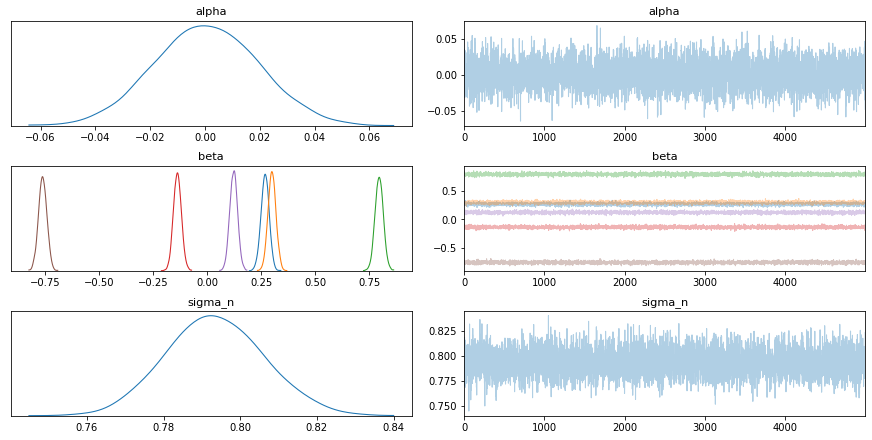

In [13]:
pm.traceplot(posterior);

We can compute also the posterior means of $\alpha,\beta$ that we can use to compute points predictions. Note that, given thatthe posteriors are symmetric and have a single maximum, the posterior mean concides with the MAP estimates.

In [14]:
print(np.mean(posterior['alpha']), np.mean(posterior['beta'],axis=0))

0.0006320393624652555 [ 0.26809429  0.30019795  0.79573695 -0.1371284   0.12285266 -0.75985772]


We can now compute the performance metrics:

In [15]:
y_pred_BLR=yscaler.inverse_transform(np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xtestn.T))
print("MAE=",(np.mean(abs(y_pred_BLR-ytest_price))))
print("MAPE=",(np.mean(abs(y_pred_BLR-ytest_price)/ytest_price)))

MAE= 234673.41209862943
MAPE= 0.396159831130013


We obtained a similar error to `sklearn` linear regression, but our probabilistic model can provide us a lot of additional information that we can use to improve it.

In fact, there are other ways of assessing a probabilistic model then simply computing the MAE on the test set.
A probabilistic model is a generative model, so we can use its ability of generating data to check if it can generate a dataset similar to the observed output (price in the training data).
If it cannot do that, it means that our probabilistic model is not a fully correct model of the data.

This simulation is called **posterior predictive check**.

Posterior predictive checks means simulating replicated data from the posterior and then comparing these to the observed data. So, we use posterior predictive to look for systematic discrepancies between real and simulated data. 

First of all we write a function that used the samples from the posterior and our probabilistic model to generate **house prices**.

In [16]:
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred



**Is it clear how the above code works?**

We can now generate data from the posterior and compare the generate data with the true price using a density plot

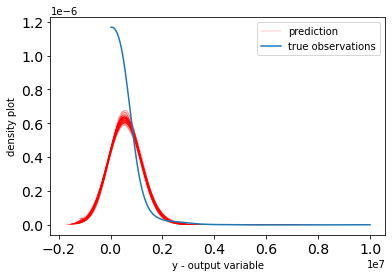

In [17]:
#Simulation
Ypred = ppc(posterior['alpha'],posterior['beta'],posterior['sigma_n'],Xn,  nsamples=80)
for i in range(Ypred.shape[0]):
    az.plot_dist( yscaler.inverse_transform(Ypred[i,:]),color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(yscaler.inverse_transform(Ypred[i,:]),color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
az.plot_dist(y,label='true observations');
plt.legend()
plt.xlabel("y - output variable")
plt.ylabel("density plot");

The blue line is the density plot of the true-prices in the training dataset.
Each red line is the density plot of a simulation of  house prices for all instances in the training dataset.
The difference between the red lines is due to the different sample of $\alpha,\beta,\sigma_n$ from the posterior used.

Using only the training data, we can notice that our linear regression model is not a good generative model for the dataset, because
1. it returns negative prices 
2. it cannot generate prices above 4000000 

Note that, we do not want the the red lines and the blue line be exactly equal, but we only want to assess if our model gives us valid predictions about the reality. Posterior predictive checks is a helpful phase of model building and checking. 

We will now attempt to solve the two problems transforming the data using the logarithm (we saw data transformation in "Data Analytics").


In [18]:
ylog=np.log(y)
yscaler = StandardScaler().fit(ylog)
yn=yscaler.transform(ylog)

with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn.shape[1])#we have a beta for each column of Xn
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression relationship
    mu = alpha + pm.math.dot(beta, Xn.T)#linear regression model in matrix form
    #likelihood
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn[:,0])# be sure that observed is a 1d vector
    

Average Loss = 2,575.2: 100%|██████████| 30000/30000 [00:06<00:00, 4506.91it/s]
Finished [100%]: Average Loss = 2,575.2


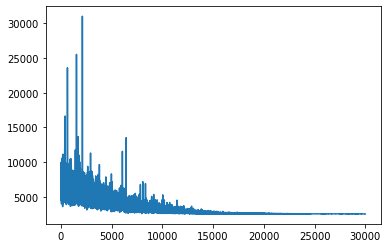

In [19]:
with model:
    approximation = pm.fit(30000,method='advi')#50000 are the number of iterations of the algorithms
#we check the convergence
plt.plot(approximation.hist);

In [20]:
posterior = approximation.sample(5000)#we sample 5000 samples from the posterior

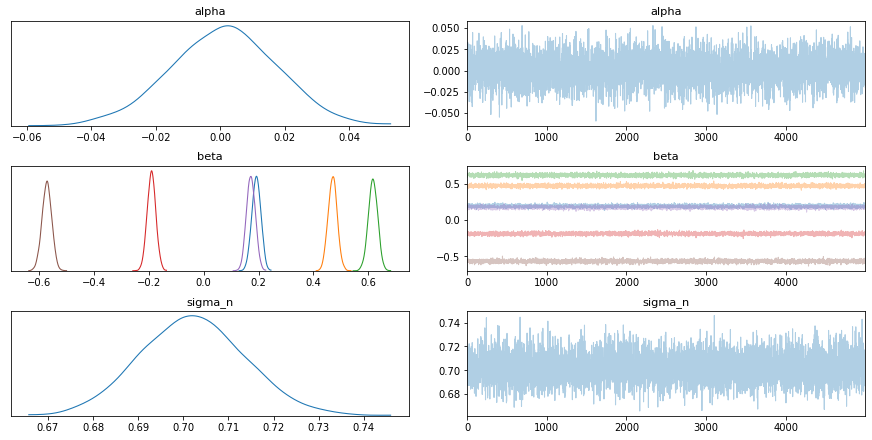

In [21]:
pm.traceplot(posterior);

In [22]:
y_pred_BLR=np.exp(yscaler.inverse_transform(np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xtestn.T)))
print("MAE=",(np.mean(abs(y_pred_BLR-ytest_price))))
print("MAPE=",(np.mean(abs(y_pred_BLR-ytest_price)/ytest_price)))

MAE= 209869.61776211177
MAPE= 0.2801165870404352


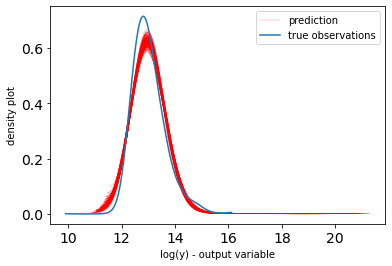

In [23]:
#Simulation
Ypred = ppc(posterior['alpha'],posterior['beta'],posterior['sigma_n'],Xn,  nsamples=200)
for i in range(Ypred.shape[0]):
    az.plot_dist( yscaler.inverse_transform(Ypred[i,:]),color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(yscaler.inverse_transform(Ypred[i,:]),color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

Now it is much better, but there is a weird behavior. The right tail of our simulated dataset is to high. 
We generated prices with value greater than 10000000 ($exp(16.2)$) euros. It is weird considering that we do not have so expensive houses in the training dataset.

Let's check the instances in the training dataset that lead to so high house prices. Again we can do it with our ppc function.

### Select weird instances  in the training data

In [24]:
Ypred = ppc(posterior['alpha'],posterior['beta'],posterior['sigma_n'],Xn,  nsamples=5000)
U=[]
IND=[]
for i in range(Ypred.shape[0]):#for each sample
    ind=np.where(yscaler.inverse_transform(Ypred[i,:])>17)[0]
    
    if len(ind)>0:
        IND.append(ind)
        U.append(np.hstack([X[ind,0:5],y[ind]]))
np.set_printoptions(suppress=True)
U=np.unique(np.vstack(U),axis=0)
print("weird instances")
U

weird instances


array([[      1.       ,       3.       ,      79.       ,
             52.5018563,      -1.744995 ,  199000.       ],
       [      6.       ,      14.       ,     420.2      ,
             53.368185 ,      -6.259181 , 1800000.       ],
       [     15.       ,      15.       ,     318.2      ,
             53.335109 ,      -6.331515 ,  775000.       ],
       [     15.       ,      15.       ,     700.       ,
             53.287504 ,      -6.146605 , 1500000.       ],
       [     18.       ,      27.       ,    1490.       ,
             53.260955 ,      -6.117266 , 4500000.       ]])

In [25]:
np.unique(np.hstack(IND),axis=0)

array([  42,  166,  326,  537, 1201])

In [26]:
X[np.unique(np.hstack(IND),axis=0),:]

array([[     15.       ,      15.       ,     700.       ,
             53.287504 ,      -6.146605 ,  490000.       ],
       [     18.       ,      27.       ,    1490.       ,
             53.260955 ,      -6.117266 , 2220100.       ],
       [      6.       ,      14.       ,     420.2      ,
             53.368185 ,      -6.259181 ,  176568.04     ],
       [      1.       ,       3.       ,      79.       ,
             52.5018563,      -1.744995 ,    6241.       ],
       [     15.       ,      15.       ,     318.2      ,
             53.335109 ,      -6.331515 ,  101251.24     ]])

This may be outliers (at least for our linear regression model). Note that the longitude is clearly wrong for the first house in `U`. We can remove  this point from the training dataset and recompute our inferences.

In [33]:
X = df_subset_train.iloc[:,0:-1].values #input columns
y = df_subset_train.iloc[:,-1].values.reshape(-1,1)   #output column, price
dfyte=pd.read_csv("../datasets/house_price_csv/true_price.csv")
ytest_price=dfyte.Expected.values

#test set
Xtest = df_subset_test.iloc[:,0:].values #input columns

#Cleaning
ind=np.where((X[:,0]==0) & (X[:,1]==0))[0]
X=np.delete(X,ind,axis=0)#0 bathrooms, 0 bedrooms
y=np.delete(y,ind,axis=0)#0 bathrooms, 0 bedrooms

ind=np.where((X[:,2]==0))[0]
X=np.delete(X,ind,axis=0)#0 surface
y=np.delete(y,ind,axis=0)#0 surface

#Cleaning
ind=np.where((Xtest[:,0]==0) & (Xtest[:,1]==0))[0]
Xtest=np.delete(Xtest,ind,axis=0)#0 bathrooms, 0 bedrooms

ytest_price=np.delete(ytest_price,ind,axis=0)#0 bathrooms, 0 bedrooms

#removeing possible outliers

IND=np.array([  42,  166,  326,  537, 1201]) #np.unique(np.hstack(IND),axis=0)
X=np.hstack([X,X[:,[2]]**2])
X=np.delete(X,IND,0)
xscaler = StandardScaler().fit(X)
Xn=xscaler.transform(X)
Xtest=np.hstack([Xtest,Xtest[:,[2]]**2])
Xtestn=xscaler.transform(Xtest)
y=np.delete(y,IND,0)
yscaler = StandardScaler().fit(y)
yn=yscaler.transform(y)

In [34]:
Xn.shape

(2358, 6)

In [35]:
ylog=np.log(y)
yscaler = StandardScaler().fit(ylog)
yn=yscaler.transform(ylog)

with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn.shape[1])#we have a beta for each column of Xn
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression relationship
    mu = alpha + pm.math.dot(beta, Xn.T)#linear regression model in matrix form
    #likelihood
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn[:,0])# be sure that observed is a 1d vector
    

Average Loss = 2,188.2: 100%|██████████| 50000/50000 [00:15<00:00, 3254.16it/s]
Finished [100%]: Average Loss = 2,188.2


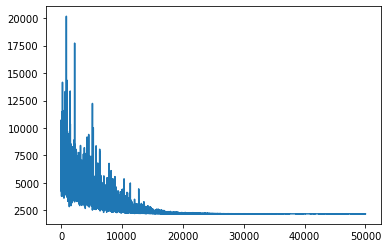

In [36]:
with model:
    approximation = pm.fit(50000,method='advi')#50000 are the number of iterations of the algorithms
#we check the convergence
plt.plot(approximation.hist);

In [37]:
posterior = approximation.sample(5000)#we sample 5000 samples from the posterior

In [38]:
y_pred_BLR=np.exp(yscaler.inverse_transform(np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xtestn.T)))
print("MAE=",(np.mean(abs(y_pred_BLR-ytest_price))))
print("MAPE=",(np.mean(abs(y_pred_BLR-ytest_price)/ytest_price)))

MAE= 204243.03778114737
MAPE= 0.2770136732521092


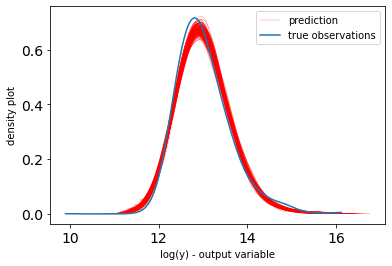

In [39]:
#Simulation
Ypred = ppc(posterior['alpha'],posterior['beta'],posterior['sigma_n'],Xn,  nsamples=200)
for i in range(Ypred.shape[0]):
    az.plot_dist( yscaler.inverse_transform(Ypred[i,:]),color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(yscaler.inverse_transform(Ypred[i,:]),color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

We haven't full solved the problem,  there are still some differences. In particular, the maximum of the true density and the simulated ones is not exactly matching and we have a longer right tail and shorter left tail.

Should we change again the model? 

Yes we should do it, but we should also consider that we are using a simple linear model and so we should not expect much. So a next step should be to move to a nonlinear model (like a neural network for instance). We will see that in another notebook.

Posterior predictive checks involve a double-use of the data, which is dangerous if then we also change the prior over our parameters to "better fit the data".  Therefore,  posterior predictive checks can be used provided that usage is limited to measures of discrepancy to study model adequacy, not for fitting the model to the data.

To be sure that we are not violating this principle we can (should) perform the posterior predictive checks on the test set too.

### PPC on the Test set



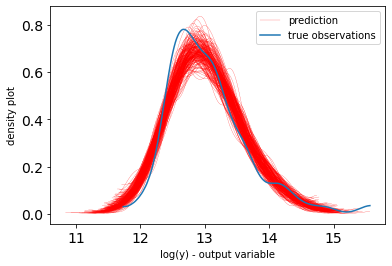

In [40]:
#Simulation TEST SET
Ypred = ppc(posterior['alpha'],posterior['beta'],posterior['sigma_n'],Xtestn,  nsamples=200)
for i in range(Ypred.shape[0]):
    az.plot_dist( yscaler.inverse_transform(Ypred[i,:]),color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(yscaler.inverse_transform(Ypred[i,:]),color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(np.log(ytest_price),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

We can say that our model is close to the true distribution of the data, although there are some important differences. For instance the blue density plot is clearly skewed (asymmetrical), while our model returns symmetric densities (when we generate the prices).

We must also consider that we are just using linear regression and we can improve the prediction by using more
complex models.

Note also that there is more uncertainty in the test set (this can be seen from the greater difference between the red densities). 